# Bayes by Backprop

In [15]:
import time
import tqdm
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from collections import OrderedDict
plt.style.use('ggplot')

In [2]:
class Gaussian_scale_mix:
    """Computes log-likelihood probability of Gaussian scale mixture"""
    def __init__(self, sigma1, sigma2, pi):
        self.sigma1 = torch.tensor([sigma1], dtype=torch.float)
        self.sigma2 = torch.tensor([sigma2], dtype=torch.float)
        self.pi = pi

    def log_prob(self, weight):
        sigma = self.pi*self.sigma1 + (1-self.pi)*self.sigma2
        log_prob = float(-0.5*torch.log(2*torch.tensor([math.pi]))) \
                   - torch.log(torch.abs(sigma)) \
                   - (weight)**2/(2*sigma**2)
        return log_prob

In [3]:
class BayesLinearModel(nn.Module):
    """
    Creates an object of a bayesian linear model which is used as a layer in a Bayesian Neural Network.

    Methods
    -------
    forward(x, infer=False)
        Propagates forward calculation. If inference is True, returns
        a mean value
    prior_loss
        Computes prior part of a loss function
    variat_loss
        computes variational part of a loss function
    """

    def __init__(self, input_dim, output_dim, sigma1, sigma2, pi, fit_prior=False):
        """
        Parameters
        ----------
        inpute_dim : int
            Input dimension of a layer
        output_dim : int
            Output dimension of a layer
        sigma1 : float
            Variance of a parameter
        sigma2 : float
            Variance of a parameter used to create a distribution tight around mean value
        pi : float
            Proportion of using sigma1 as variance
        fit_prior : bool
            Specification of prior wanted to be trained
        """
        super(BayesLinearModel, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        # If prior is trained, specify as a parameter, otherwise fixed
        if fit_prior:
            self.sigma1 = nn.Parameter(torch.Tensor([sigma1]),
                                       requires_grad=True)
            self.sigma2 = nn.Parameter(torch.Tensor([sigma2]),
                                       requires_grad=True)
            self.pi = nn.Parameter(torch.Tensor([pi]),
                                   requires_grad=True)
        else:
            self.sigma1 = sigma1
            self.sigma2 = sigma2
            self.pi = pi
        # Total parameter variance
        self.sigma = self.pi * self.sigma1 + (1 - self.pi) * self.sigma2
        self.rho_std = float(np.log(np.exp(self.sigma) - 1))

        # Initialize parameters for q(w/theta)-variational distribution

        # Weight mean
        # self.w_mu = nn.Parameter(torch.Tensor(
        #    self.input_dim,
        #    self.output_dim).normal_(0.0, float(self.sigma)),
        #                         requires_grad=True)

        self.w_mu = nn.Parameter(torch.zeros(
            [self.input_dim,
             self.output_dim]), requires_grad=True)
        # Weight rho used in variance
        self.w_rho = nn.Parameter(torch.Tensor(
            self.input_dim,
            self.output_dim).uniform_(1.05 * self.rho_std, 0.95 * self.rho_std),
                                  requires_grad=True)
        # Bias mean
        self.b_mu = nn.Parameter(torch.zeros(
            self.output_dim), requires_grad=True)
        # Bias rho used in variance
        self.b_rho = nn.Parameter(torch.Tensor(
            self.output_dim).uniform_(1.05 * self.rho_std, 0.95 * self.rho_std),  # 0.5 maybe ?
                                  requires_grad=True)
        self.qw_loss = 0.0  # Variational loss
        self.pw_loss = 0.0  # Prior loss

    def forward(self, x, infer=False):
        """
        Parameters
        ----------
        x : array-like
            features array
        infer : bool
            if True, the method computes the Maximum Likelihood Estimate
        Returns
        -------
        output : array-lile
            prediction of the layer
        """
        # Compute mean prediction - maximum likelihood estimation (MLE)
        if infer:
            output = torch.mm(x, self.w_mu) + self.b_mu
            return output
        # Sample noise
        w_eps = torch.distributions.Normal(0.0, 1.0).sample((self.w_mu.size()))
        b_eps = torch.distributions.Normal(0.0, 1.0).sample((self.b_mu.size()))
        # Compute variance of weight and bias of variational distribution
        w_std = torch.log(1 + torch.exp(self.w_rho))
        b_std = torch.log(1 + torch.exp(self.b_rho))
        # Compute weights and bias samples of variational distribution
        w_sample = self.w_mu + w_std * w_eps
        b_sample = self.b_mu + b_std * b_eps
        # Compute layer output
        output = torch.mm(x, w_sample) + b_sample
        # Compute Kullback-Leibler loss
        self.pw_loss = self.prior_loss(w_sample, 0.0, self.sigma1,
                                       self.sigma2, self.pi).sum() \
                       + self.prior_loss(b_sample, 0.0, self.sigma1,
                                         self.sigma2, self.pi).sum()
        self.qw_loss = self.variat_loss(w_sample, self.w_mu, w_std).sum() \
                       + self.variat_loss(b_sample, self.b_mu, b_std).sum()

        return output

    def prior_loss(self, x, mu, sigma1, sigma2, pi):
        """
        Computes prior part of a loss function

        Parameters
        ----------
        x : array-like
            true value of the target
        mu : array-like
            mean
        sigma1 : float
            variance of the parameters
        sigma2 : float
            variance of the parameters
        pi : float
            prbability of sigma1
        Returns
        -------
        value of the prior loss
        """
        prior_dist = Gaussian_scale_mix(sigma1, sigma2, pi)
        return prior_dist.log_prob(x)

    def variat_loss(self, x, mu, sigma):
        """Computes variational part of a loss function
        Parameters
        ----------
        x : array-like
            true value of the target
        mu : array-like
            estimate of the target
        sigma : float
            variance of the parameter
        """
        variat_dist = float(-0.5 * torch.log(2 * torch.tensor([math.pi]))) \
                      - torch.log(torch.abs(sigma)) \
                      - (x - mu) ** 2 / (2 * sigma ** 2)
        return variat_dist

In [4]:
class Bayesian_MLP(nn.Module):
    """
    Creates an object of a Bayesian Neural Network with specified number of layers, units and variance of 
    the parameters. Has also capabilties to tune prior and estimate noise of the data.
    Able to work with homo- and heteroscedastic uncertainties.

    Methods
    -------
    forward
        Computes forward propagation
    get_loss
        Returns values of prior and variational loss
    """

    def __init__(self, noise_type, n_input, n_layers, n_units, n_output, sigma1, sigma2, pi, sigma_noise,
                 fit_prior=False, fit_noise=False):
        """
        Parameters
        ----------
        noise_type : str("homo" or "hetero"):
            Specification of noise type: homo- or heteroscedastic
        n_input : int
            Size of input feature space
        n_layers : int
            Number of layers
        n_units : int
            Number of units in each layer (equal for all layers)
        n_outputs : int
            Number of output nodes
        sigma1 : float
            Value of parameter variance
        sigma2 : float
            Scond value of parameter variance
        pi : float
            Proportion of using sigma1 as variance
        sigma_noise : float
            Variance of data noise. If fit_noise is True, used as an nitial value in tuning
        """
        super(Bayesian_MLP, self).__init__()
        self.n_layers = n_layers
        # Homoscedastic uncertainty case
        if noise_type == "homo":
            self.n_output = n_output
            # If noise is learned, specify as parameter, otherwise fixed
            if fit_noise:
                self.sigma_noise = nn.Parameter(torch.tensor([sigma_noise]),
                                                requires_grad=True)
            else:
                self.sigma_noise = torch.tensor([sigma_noise])
        # Heterscedastic uncertainty case
        elif noise_type == "hetero":
            # Need two inputs: one for mean and one for variance
            self.n_output = 2 * n_output
        else:
            raise Exception("Noise type must be specified as homo or hetero")
        # Specify a module dictionary of weights using linear model objects
        self.layers = nn.ModuleDict(OrderedDict(
            {
                # input-hidden weights
                "l_input": BayesLinearModel(n_input, n_units,
                                            sigma1, sigma2, pi,
                                            fit_prior),
                # hidden-hidden weights
                "l_hidden": BayesLinearModel(n_units, n_units,
                                             sigma1, sigma2, pi,
                                             fit_prior),
                # hidden-output weights
                "l_out": BayesLinearModel(n_units, self.n_output,
                                          sigma1, sigma2, pi,
                                          fit_prior)
            }))
        self.activation = nn.ModuleDict({"relu": nn.ReLU()})

    def forward(self, x, infer=False):
        """
        Computes forward propagation of the network"
        Parameters
        ----------
        x : array-like
            features array
        infer : bool
            if True, computes the maximum likelihood estimate

        Returns
        -------
        output : array-like
            output of the network

        """
        for layer in range(self.n_layers):
            if layer == 0:
                output = self.layers["l_input"](x, infer)
                output = self.activation["relu"](output)
            else:
                output = self.layers["l_hidden"](output, infer)
                output = self.activation["relu"](output)
        output = self.layers["l_out"](output, infer)
        return output

    def get_loss(self):
        """Computes prior and variational part of loss"""
        prior_loss, variat_loss = 0., 0.
        for layer in range(self.n_layers):
            if layer == 0:
                prior_loss += self.layers["l_input"].pw_loss
                variat_loss += self.layers["l_input"].qw_loss
            else:
                prior_loss += self.layers["l_hidden"].pw_loss
                variat_loss += self.layers["l_hidden"].qw_loss
        prior_loss += self.layers["l_out"].pw_loss
        variat_loss += self.layers["l_out"].qw_loss
        return prior_loss, variat_loss

In [5]:
class BBP_fit:
    """Fits a Bayesian Neural Network with specified parameters"""
    def __init__(self, noise_type, n_input, n_output, n_layers, n_units, learn_rate, batch_size,
                 n_batches, sigma1, sigma2, pi, sigma_noise, fit_prior, fit_noise):
        """
        Parameters
        ----------
        noise_type : str("homo" or "hetero"):
            Specification of noise type: homo- or heteroscedastic
        n_input : int
            Size of input feature space
        n_layers : int
            Number of layers
        n_units : int
            Number of units in each layer (equal for all layers)
        n_outputs : int
            Number of output nodes
        learn_rate : float
            learning rate
        batch_size : int
            size of the batch in training
        n_batches : int
            number of batches
        sigma1 : float
            Value of parameter variance
        sigma2 : float
            Scond value of parameter variance
        pi : float
            Proportion of using sigma1 as variance
        sigma_noise : float
            Variance of data noise. If fit_noise is True, used as an nitial value in tuning
        fit_prior : bool
            if wanted, prior can be learned from the data 
        fit_noise : bool
            if wanted, noise can be learned from the data
        """
        # Soecify training parameters
        self.batch_size = batch_size
        self.n_batches = n_batches
        self.noise_type = noise_type
        # Create a neural network object
        self.network = Bayesian_MLP(noise_type, n_input, n_layers,
                                    n_units, n_output, sigma1, sigma2,
                                    pi, sigma_noise, fit_prior, fit_noise)
        # Create an optimizer object
        self.optimizer = torch.optim.RMSprop(self.network.parameters(),
                                             lr=learn_rate)
        self.train_loss = []
        self.prior_loss = []
        self.variat_loss = []
        self.log_lik = []

    def fit(self, x, y, n_samples):
        """
        Trains a Bayesian Neural Network"
        Parameters
        ----------
        x : array-like
            training set of data
        y : array-like
            target
        n_samples : int
            number of samples to be drawn from in each epoch of training
        Returns
        -------
        loss : float
            value of the total loss during training
        """
        self.optimizer.zero_grad()
        X = Variable(torch.Tensor(x))
        y = Variable(torch.Tensor(y))
        s_log_pw, s_log_qw, s_log_likelihood = 0., 0., 0.

        for _ in range(n_samples):
            output = self.network(X)
            sample_log_pw, sample_log_qw = self.network.get_loss()

            # Compute log_likelihood loss for homo- or heteroscedastic uncertainty
            if self.noise_type == "homo":
                sample_log_likelihood = self.log_likelihood(y, output,
                                                            self.network.sigma_noise).sum()
            elif self.noise_type == "hetero":
                sigma = output[:, 1:] / 1e2  # Divide sigma to prevent loss exploading
                sample_log_likelihood = self.log_log_likelihood(y,
                                                                output[:, :1], sigma).sum()
                # Sum up sample loss to the total loss of each loss part
            s_log_pw += sample_log_pw
            s_log_qw += sample_log_qw
            s_log_likelihood += sample_log_likelihood
        # Compute total loss 
        loss = self.total_loss(s_log_pw / n_samples,
                               s_log_qw / n_samples,
                               s_log_likelihood / n_samples)
        self.train_loss.append(loss.data.cpu().numpy())
        # Optimize loss and adjust weights
        loss.backward()
        self.optimizer.step()
        # Getting losses for tracking and debugging
        self.prior_loss.append(s_log_pw / n_samples)
        self.variat_loss.append(s_log_qw / n_samples)
        self.log_lik.append(s_log_likelihood / n_samples)
        return loss

    def total_loss(self, l_pw, l_qw, l_likelihood):
        """Computes totla loss using prior, variationa and likelihood parts
        """
        total_loss = ((1. / self.n_batches) * (l_qw - l_pw) - l_likelihood).sum() / float(self.batch_size)
        return total_loss

    def log_likelihood(self, x, mu, sigma):
        """Computes log-likelihood loss"""
        log_lik = float(-0.5 * torch.log(2 * torch.tensor([math.pi]))) \
                  - torch.log(torch.abs(torch.as_tensor(sigma))) \
                  - (x - mu) ** 2 / (2 * sigma ** 2)
        return log_lik

    def log_log_likelihood(self, x, mu, log_sigma):
        """Computes loglikelihood for heteroscedastic case"""
        log_lik = float(-0.5 * torch.log(2 * torch.tensor([math.pi]))) \
                  - torch.as_tensor(log_sigma) \
                  - ((x - mu) ** 2) * (2 * torch.exp(-log_sigma))
        return log_lik

In [6]:
def plot_BBP(x_train, y_train, x_test, y_test, train_pred, test_pred, aleatoric_train, 
             epistemic_train, total_unc_train, aleatoric_test, epistemic_test, total_unc_test):
    """Plots predictions on training and test sets together with uncertainty"""
    plt.figure(figsize=(10, 15))
    # Training set
    ax = plt.subplot(2, 1, 1)
    # Epistemic uncertainty
    alpha=0.25
    plt.fill_between(x_train, train_pred + 2*aleatoric_train, 
                     train_pred + 2*total_unc_train, 
                     color="powderblue", alpha=alpha)
    plt.fill_between(x_train, train_pred + 1.5*aleatoric_train, 
                 train_pred + 1.5*total_unc_train, 
                 color="lightblue", alpha=alpha)
    plt.fill_between(x_train, train_pred + 1*aleatoric_train, 
                     train_pred + 1*total_unc_train, 
                     color="skyblue", alpha=alpha)
    plt.fill_between(x_train, train_pred + 0.5*aleatoric_train,
                     train_pred + 0.5*total_unc_train,
                     color="lightskyblue", alpha=alpha)
    # Below
    plt.fill_between(x_train, train_pred - 2*aleatoric_train, 
                 train_pred - 2*total_unc_train, 
                 color="powderblue", alpha=alpha)
    plt.fill_between(x_train, train_pred - 1.5*aleatoric_train, 
                 train_pred - 1.5*total_unc_train, 
                 color="lightblue", alpha=alpha)
    plt.fill_between(x_train, train_pred - 1*aleatoric_train, 
                     train_pred - 1*total_unc_train, 
                     color="skyblue", alpha=alpha)
    plt.fill_between(x_train, train_pred - 0.5*aleatoric_train,
                     train_pred - 0.5*total_unc_train,
                     color="lightskyblue", alpha=alpha)
    # Alearotic uncertainty 
    plt.fill_between(x_train, train_pred - 2*aleatoric_train, 
                     train_pred + 2*aleatoric_train,
                     color="lightyellow", alpha=0.8)
    # Data/predictions plot
    plt.plot(x_train, y_train, color="red", linestyle='dashed',
             linewidth=2.5, label="Training data")
    plt.plot(x_train, train_pred, label="Mean", color="darkblue", 
             alpha=0.8, linewidth=2.5)
    plt.legend(prop={'size': 20})
    
    # Test set
    ax2 = plt.subplot(2, 1, 2, sharey=ax)
    # Epistemic uncertainty
    # Above
    alpha=0.25
    plt.fill_between(x_test, test_pred + 2*aleatoric_test, 
                     test_pred + 2*total_unc_test, 
                     color="powderblue", alpha=alpha)
    plt.fill_between(x_test, test_pred + 1.5*aleatoric_test, 
                 test_pred + 1.5*total_unc_test, 
                 color="lightblue", alpha=alpha)
    plt.fill_between(x_test, test_pred + 1*aleatoric_test, 
                     test_pred + 1*total_unc_test, 
                     color="skyblue", alpha=alpha)
    plt.fill_between(x_test, test_pred + 0.5*aleatoric_test,
                     test_pred + 0.5*total_unc_test,
                     color="lightskyblue", alpha=alpha)
    # Below
    plt.fill_between(x_test, test_pred - 2*aleatoric_test, 
                 test_pred - 2*total_unc_test, 
                 color="powderblue", alpha=alpha)
    plt.fill_between(x_test, test_pred - 1.5*aleatoric_test, 
                 test_pred - 1.5*total_unc_test, 
                 color="lightblue", alpha=alpha)
    plt.fill_between(x_test, test_pred - 1*aleatoric_test, 
                     test_pred - 1*total_unc_test, 
                     color="skyblue", alpha=alpha)
    plt.fill_between(x_test, test_pred - 0.5*aleatoric_test,
                     test_pred - 0.5*total_unc_test,
                     color="lightskyblue", alpha=alpha)
    
    # Alearotic uncertainty 
    plt.fill_between(x_test, test_pred - 2*aleatoric_test, 
                     test_pred + 2*aleatoric_test,
                     color="lightyellow", alpha=0.8)
    # Data/predictions plot
    plt.plot(x_test, y_test, color="red", linestyle='dashed',
             linewidth=2.5, label="Test data")
    plt.plot(x_test, test_pred, label="Mean", color="darkblue", 
             alpha=0.8, linewidth=2.5)
    plt.grid(False)
    plt.tight_layout()
    plt.legend(prop={'size': 20})

In [7]:
def param_analysis(network):
    """
    Analyses (plots) the parameters of the network distributions
    """
    param_dict = {}
    param_list_w_mu = []
    param_list_w_rho = []
    param_list_b_mu = []
    param_list_b_rho = []

    for name, param in network.network.named_parameters():
        param_dict[name] = param

    for name in param_dict:
        if "w_mu" in name:    
            param_list_w_mu.append(param_dict[name].tolist())
        elif "w_rho" in name:    
            param_list_w_rho.append(param_dict[name].tolist())
        elif "b_mu" in name:
            param_list_b_mu.append(param_dict[name].tolist())
        elif "b_rho" in name:    
            param_list_b_rho.append(param_dict[name].tolist()) 

    w_mu_flat = np.array([item for sublist in param_list_w_mu 
                          for subsublist in sublist 
                          for item in subsublist])
    w_rho_flat = np.array([item for sublist in param_list_w_rho 
                           for subsublist in sublist 
                           for item in subsublist])
    b_mu_flat = np.array([item for sublist in param_list_b_mu 
                          for item in sublist])
    b_rho_flat = np.array([item for sublist in param_list_b_rho 
                           for item in sublist])
    
    return w_mu_flat, w_rho_flat, b_mu_flat, b_rho_flat

In [8]:
def param_plot(w_mu, w_rho, b_mu, b_rho):
    plt.figure(figsize=(20, 5))
    
    data = [w_mu, w_rho, b_mu, b_rho]
    data_names = ["w_mu", "w_rho", "b_mu", "b_rho"]
    
    for i, plot_data in enumerate(data):
        plt.subplot(1, 4, i+1)
        plt.hist(plot_data)
        plt.title(data_names[i])

# Training

In [9]:
data_mat = scipy.io.loadmat('Boosting_data_11.mat') # Oil production data
data_mat_test = scipy.io.loadmat('Boosting_data_11_test.mat') # Oil well test data

# Names of the variables contained in the data
names = ['oil_rate_meter', 'gas_rate', 'gas_rate_meter', 
         'choke_opening', 'P_WF', 'T_WF', 'P_WHCU', 
         'T_WHCU', 'P_WHCD', 'T_WHCD', 'P_riser', 'T_riser'
        ]
# Start forming the dataset from the .mat file
data = pd.DataFrame(data_mat['oil_rate_bbl'])
# Append the data into data frame from the MATLAB file
for name in names:
    data = pd.concat([data, pd.DataFrame(data_mat[name])], axis=1, ignore_index=True)
    
data = pd.DataFrame(data.values, columns=['oil_rate_bbl', 'oil_rate_meter', 
                                          'gas_rate', 'gas_rate_meter', 
                                          'choke_opening', 'P_WF', 'T_WF',
                                          'P_WHCU', 'T_WHCU', 'P_WHCD', 
                                          'T_WHCD', 'P_riser','T_riser'
                                         ])

X = data.drop(columns=['oil_rate_bbl', 'oil_rate_meter', 
                       'gas_rate', 'gas_rate_meter',
                       'P_riser', 'T_riser'], inplace=False)
y = data["oil_rate_meter"]

In [10]:
train_size = int(X.shape[0]*0.75)
X_train = X.values[:train_size]
Y_train = y.values[:train_size].reshape(-1, 1)
X_test = X.values[train_size:]
Y_test = y.values[train_size:].reshape(-1, 1)

x_mean, x_std = X_train.mean(axis = 0), X_train.std(axis = 0)
y_mean, y_std = Y_train.mean(axis = 0), Y_train.std(axis = 0)

x_train = (X_train - x_mean)/x_std
y_train = (Y_train- y_mean)/y_std #Y_train.max() #(Y_train - y_mean)/y_std
x_test = (X_test - x_mean)/x_std
y_test = (Y_test- y_mean)/y_std #Y_train.max() #(Y_test - y_mean)/y_std

# Homoscedastic unidertainty

In [11]:
%%time
# Parameters
n_input = x_train.shape[1]
n_output = y_train.shape[1]
sigma_1 = 0.5
sigma_2 = 0.01
pi = 1.0
sigma_noise = 0.05
n_samples = 5
n_epochs = 1500

batch_size = y_train.shape[0]
n_batches = int(y_train.shape[0]/batch_size)

# Training
net = BBP_fit(noise_type="homo", n_input=n_input, n_output=n_output, 
              n_layers=2, n_units=10, learn_rate=0.01, batch_size=batch_size, 
              n_batches=n_batches, sigma1=sigma_1, sigma2=sigma_2, 
              pi=pi, sigma_noise=sigma_noise, fit_prior=False, fit_noise=True)
losses = []
for i in tqdm.tqdm(range(n_epochs)):
    loss = net.fit(x=x_train, y=y_train, n_samples=n_samples)
    losses.append(loss)

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:11<00:00, 20.92it/s]


Wall time: 1min 11s


# Inference

In [12]:
# Train predictions
X_train_ = Variable(torch.Tensor(x_train))
samples_train = []

for i in range(100):
    preds = net.network.forward((X_train_), infer=False)
    samples_train.append(preds.detach().numpy()*y_std + y_mean)

samples_train = np.array(samples_train)
means_train = samples_train.mean(axis=0)

# Test predictions
X_test_ = Variable(torch.Tensor(x_test))
samples_test = []

for i in range(100):
    preds = net.network((X_test_), infer=False)
    samples_test.append(preds.detach().numpy()*y_std + y_mean)
    
samples_test = np.array(samples_test)
means_test = samples_test.mean(axis=0)

# Uncertainties
# Training set
aleatoric_train = net.network.sigma_noise.detach().numpy()*y_std
epistemic_train = np.sqrt(samples_train.var(axis=0))
total_unc_train = np.sqrt(aleatoric_train**2 + epistemic_train**2)
# Test set
aleatoric_test = net.network.sigma_noise.detach().numpy()*y_std
epistemic_test = np.sqrt(samples_test.var(axis=0))
total_unc_test = np.sqrt(aleatoric_test**2 + epistemic_test**2)

In [13]:
# x-time steps for plotting
x_train_plot = np.arange(0, int(x_train.shape[0]), step=1)
x_test_plot = np.arange(0, int(x_test.shape[0]), step=1)

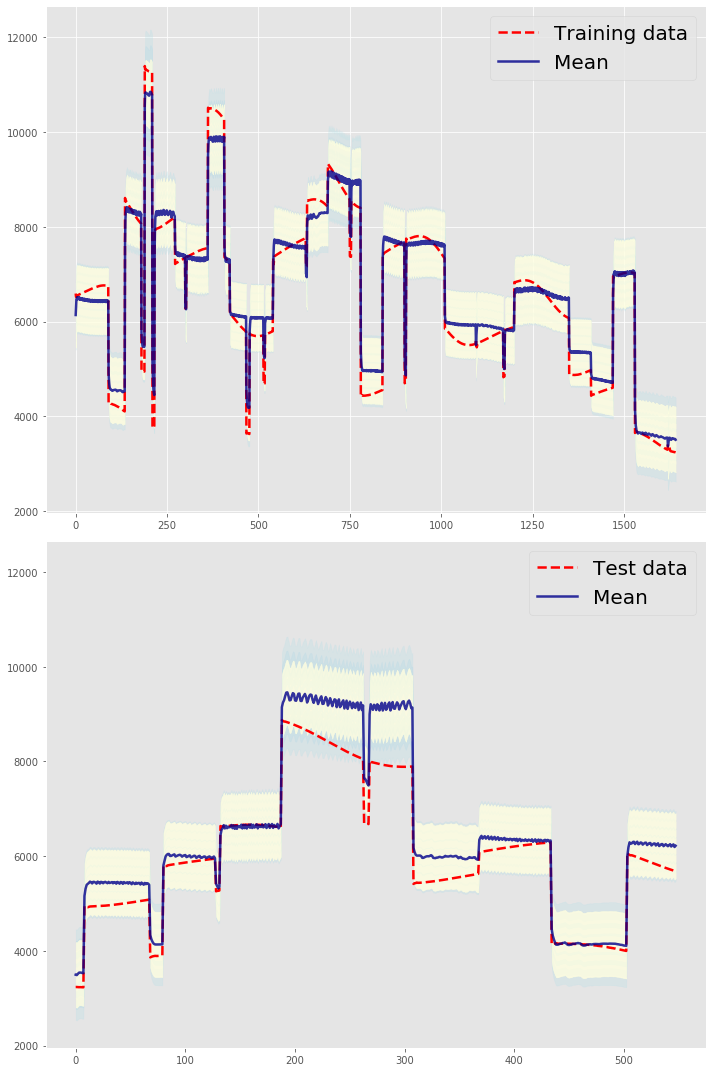

In [16]:
plot_BBP(x_train_plot.ravel(), Y_train.ravel(), x_test_plot.ravel(), 
         Y_test.ravel(), means_train.ravel(), means_test.ravel(),
         aleatoric_train, epistemic_train.ravel(), total_unc_train.ravel(), 
         aleatoric_test, epistemic_test.ravel(), total_unc_test.ravel())

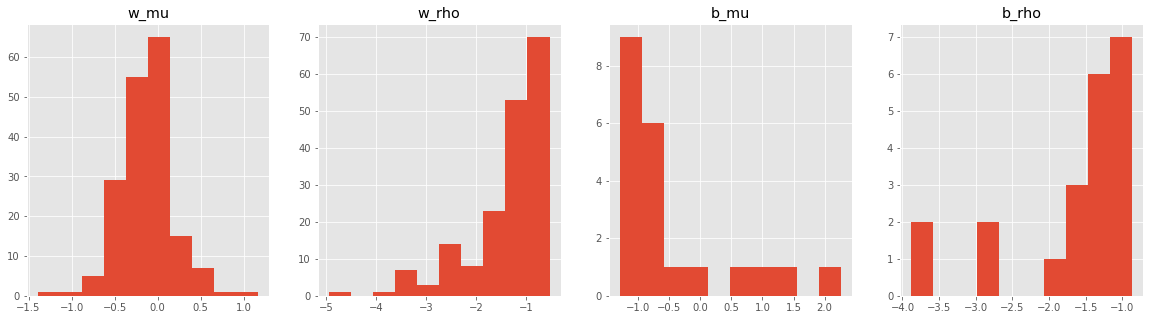

In [17]:
w_mu_flat, w_rho_flat, b_mu_flat, b_rho_flat=param_analysis(network=net)
param_plot(w_mu_flat, w_rho_flat, b_mu_flat, b_rho_flat)